# Cognitive Services Personalizer

This tutorial simulates a Multislot Personalizer loop _system_ which suggests which products a customer should buy when displayed in different slots. The users and their preferences are store in a [user dataset](simulated_users.json). Information about the products is also available in a [product dataset](products.json). Information about the slots is also available in a [slot dataset](slots.json).

A summary of the user information is:

|Customers|Days of month|Times of Day|Types of Device|
|--|--|--|--|
|Alice<br>Bob<br>Cathy|7<br>21<br>30|Morning<br>Afternoon<br>Evening|Desktop<br>Mobile|

To help Personalizer make the correct product selection for each person, the _system_ also knows details about the product.

|Product on Sale|Price|Category|
|--|--|--|
|true<br>false|20<br>70<br>200<br>499|Clothing<br>Sports<br>Electronics|

The _system_ also knows details about the slots where the recommended products will be displayed.

|Size|Position|
|--|--|
|Large<br>Small|Left<br>Right|

The **purpose** of the Personalizer loop is to find the best match between the users and the product as much of the time as possible.

## How the simulation works

At the beginning of the running system, the suggestions from Personalizer are only successful between 20% to 30% (indicated by the reward score of 1). After some requests, the system improves.

After the initial 25,000 requests, run an offline evaluation. This allows Personalizer to review the data and suggest a better learning policy. Apply the new learning policy and run the notebook again with 5,000 requests. The loop will perform better.

## Multislot Rank and Reward calls
For each of the few thousand calls to the Personalizer service, the Azure notebook sends the **Multislot Rank** request to the REST API:
* A unique ID for the Multislot Rank/Request event
* Context - A random choice of the user, day of month, time of day, and device - simulating a user on a website or mobile device 
* Features - All the product data - from which Personalizer makes a suggestion 
* Slots - All the slot information where the recommended products will be displayed

The system receives the Multislot rank of the product choices, then compares that prediction with the user's known choice for the same day of month, time of day and device. If the known choice is the same as the prediction choice, the **Reward** of 1 is sent back to Personalizer. Otherwise the reward is 0. 

> [!Note]
> This is a simulation so the algorithm for the reward is simple. In a real-world scenario, the algorithm should use business logic, possibly with weights for various aspects of the customer's experience, to determine the reward score.

## Prerequisites
* An [Azure Personalizer resource](https://ms.portal.azure.com/#create/Microsoft.CognitiveServicesPersonalizer).
* If you have already used the Personalizer resource, make sure to [clear the data](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/how-to-settings#clear-data-for-your-learning-loop) in the Azure portal for the resource.
* Upload all the files for this sample into an Azure Notebook project.


File descriptions:

* [MultislotPersonalizer.ipynb](MultislotPersonalizer.ipynb) is the Jupyter notebook for this tutorial.
* [User dataset](simulated_users.json) is stored in a JSON object.
* [Product dataset](products.json) is stored in a JSON object.
* [Slot dataset](slots.json) is stored in a JSON object.
* [Example Request JSON](example-rankrequest.json) is the expected format for a POST request to the Rank API.

## Configure Personalizer resource
    
In the Azure portal, configure your [Personalizer resource](https://ms.portal.azure.com/#create/Microsoft.CognitiveServicesPersonalizer) with the **update model frequency** set to 30 seconds and a **reward wait time** of 30 seconds. These settings are found in the Configurations tab, under the RESOURCE MANAGEMENT section.    

|Setting|Value|
|--|--|
|update model frequency|30 seconds|
|reward wait time|30 seconds|    

These values have a very short duration in order to show changes in this tutorial. These values shouldn't be used in a production scenario without validating they achieve your goal with your Personalizer loop.

## Upgrade Personalizer instance to Multislot
In the Azure portal, in the Personalizer resouce on the **Model and learning settings page**, click **Export learning settings**. The **arguments** field in the downloaded json file will start with **--cb_explore_adf**. Change this to **--ccb_explore_adf** while leaving the rest of the file untouched. Save the file. 

In the same tab in the portal, under **import learning settings** browse to find your recently modified json file and upload it. This will update your Personalizer instance to be a Multislot Personalizer and will now support Multislot Rank and Reward calls.

## Set up the Azure Notebook 
Change the Kernel to Python 3.6

## Run Notebook cells
Run each executable cell and wait for it to return.

You know it is done when the brackets next to the cell display a number instead of a `*`. Do not continue if you get an error.

The following sections explain what each cell does programmatically and what to expect for the output.

### Include the python modules
Include the required python modules. The cell has no output.

In [1]:
import json
import matplotlib.pyplot as plt
import random
import requests
import time
import uuid
import datetime

### Set Personalizer resource key and name

From the Azure portal, find your key and endpoint on the **Quickstart** page of your Personalizer resource. Change the value of `<your-resource-name>` to your Personalizer resource's name. Change the value of `<your-resource-key>` to your Personalizer key. 

The cell has no output.

In [2]:
# Replace 'personalization_base_url' and 'resource_key' with your valid endpoint values.
personalization_base_url = "https://validateccbdeployment.cognitiveservices.azure.com/"
resource_key = "5ac4380a152544518ddc18800c37ec43"

### Print current date and time
Use this function to note the start and end times of the iterative function, `iterations`.

These cells have no output. The function does output the current date and time when called.

In [3]:
# Print out current datetime
def currentDateTime():
    currentDT = datetime.datetime.now()
    print (str(currentDT))

### Get the last model update date and time

When the function, `get_last_updated`, is called, the function prints out the last modified date and time that the model was updated. 

These cells have no output. The function does output the last model training date when called.

The function uses a GET REST API to [get model properties](https://westus2.dev.cognitive.microsoft.com/docs/services/personalizer-api/operations/GetModelProperties). 

In [4]:
# initialize variable for model's last modified date
modelLastModified = ""

In [5]:
def get_last_updated(currentModifiedDate):

    print('-----checking model')

    # get model properties
    response = requests.get(personalization_model_properties_url, headers = headers, params = None)

    print(response)
    print(response.json())

    # get lastModifiedTime
    lastModifiedTime = json.dumps(response.json()["lastModifiedTime"])

    if (currentModifiedDate != lastModifiedTime):
        currentModifiedDate = lastModifiedTime
        print(f'-----model updated: {lastModifiedTime}')

### Get policy and service configruation

Validate the state of the service with these two REST calls.

These cells have no output. The function does output the service settings when called.

In [6]:
def get_service_settings():

    print('-----checking service settings')

    # get learning policy
    response = requests.get(personalization_model_policy_url, headers = headers, params = None)

    print(response)
    print(response.json())

    # get service settings
    response = requests.get(personalization_service_configuration_url, headers = headers, params = None)

    print(response)
    print(response.json())

### Construct URLs for REST calls and read JSON data files

This cell 

* builds the URLs used in REST calls 
* sets the security header using your Personalizer resource key 
* sets the random seed for the Rank event ID
* reads in the JSON data files
* calls `get_last_updated` method - learning policy has been removed in example output
* calls `get_service_settings` method

The cell has output from the call to `get_last_updated` and `get_service_settings` functions.

In [7]:
# build URLs
personalization_rank_url = personalization_base_url + "personalizer/v1.1-preview.1/multislot/rank"
personalization_reward_url = personalization_base_url + "personalizer/v1.1-preview.1/multislot/events/" #add "{eventId}/reward"
personalization_model_properties_url = personalization_base_url + "personalizer/v1.1-preview.1/model/properties"
personalization_model_policy_url = personalization_base_url + "personalizer/v1.1-preview.1/configurations/policy"
personalization_service_configuration_url = personalization_base_url + "personalizer/v1.1-preview.1/configurations/service"
headers = {'Ocp-Apim-Subscription-Key': resource_key, 'Content-Type': 'application/json'}

# context
users = "simulated_users.json"

# action features
products = "products.json"

# slot features
slots = "slots.json"

# empty JSON for Rank request
requestpath = "example-rankrequest.json"

# initialize random
random.seed(time.time())

simulated_users = None
rankactionsjsonobj = None
actionfeaturesobj = None
slotfeaturesobj = None

with open(users) as handle:
    simulated_users = json.loads(handle.read())

with open(products) as handle:
    actionfeaturesobj = json.loads(handle.read())

with open(slots) as handle:
    slotfeaturesobj = json.loads(handle.read())

with open(requestpath) as handle:
    rankactionsjsonobj = json.loads(handle.read())

get_last_updated(modelLastModified)
get_service_settings()

print(f'Users count {len(simulated_users)}')
print(f'Products count {len(actionfeaturesobj)}')
print(f'Slots count {len(slotfeaturesobj)}')

-----checking model
<Response [200]>
{'creationTime': '2021-05-07T21:41:46+00:00', 'lastModifiedTime': '2021-05-07T21:49:10+00:00'}
-----model updated: "2021-05-07T21:49:10+00:00"
-----checking service settings
<Response [200]>
{'name': '1dc71aa7b8d34440b8f5cdb01ebbe873', 'arguments': '--ccb_explore_adf --epsilon 0.20000000298023224 --power_t 0 -l 0.001 --cb_type mtr -q ::'}
<Response [200]>
{'rewardWaitTime': 'PT30S', 'defaultReward': 0.0, 'rewardAggregation': 'earliest', 'explorationPercentage': 0.2, 'modelExportFrequency': 'PT30S', 'logRetentionDays': -1, 'lastConfigurationEditDate': '2021-05-07T22:25:30', 'learningMode': 'Online', 'isAutoOptimizationEnabled': False, 'autoOptimizationFrequency': 'P28D', 'autoOptimizationStartDate': '2021-05-22T21:23:15'}
Users count 3
Products count 4
Slots count 2


### Troubleshooting the first REST call

This previous cell is the first cell that calls out to Personalizer. Make sure the REST status code in the output is `<Response [200]>`. If you get an error, such as 404, but you are sure your resource key and name are correct, reload the notebook.

Make sure the count of users, products and slots are 3, 4 and 2 respectively. If you get an error, check that you uploaded all 4 JSON files. 

### Set up metric chart in Azure portal

Later in this tutorial, the long running process of 25,000 requests is visible from the browser with an updating text box. It may be easier to see in a chart or as a total sum, when the long running process ends. To view this information, use the metrics provided with the resource. You can create the chart now that you have completed a request to the service, then refresh the chart periodically while the long running process is going.

1. In the Azure portal, select your Personalizer resource.
1. In the resource navigation, select **Metrics** underneath Monitoring. 
1. In the chart, select **Add metric**.
1. The resource and metric namespace are already set. You only need to select the metric of **successful calls** and the aggregation of **sum**.
1. Change the time filter to the last 4 hours.

    You should see three successful calls in the chart. 

### Generate a unique event ID
This function generates a unique ID for each rank call. The ID is used to identify the rank and reward call information. This value could come from a business process such as a web view ID or transaction ID.

The cell has no output. The function does output the unique ID when called.

In [8]:
def add_event_id(rankjsonobj):
    eventid = uuid.uuid4().hex
    rankjsonobj["eventId"] = eventid
    return eventid

### Get random user, day of month, time of day and device 

This function selects a unique user, day of month, time of day, and device, then adds those items to the JSON object to send to the Multislot Rank request. 

The cell has no output. When the funciton is called it returns the random user's name, random day of month, random time of day and random device. 

The list of 3 users and their preferences - only some preferences are shown for brevity:

```json
{
	"Alice": {
		"7": {
			"Morning": {
				"Desktop": {
					"BigHeroPosition": [],
					"SmallSidebar": ["Tennis-Racket-133"]
				}...
			}
		}
	},
	"Bob": {
		"7": {
			"Morning": {
				"Desktop": {
					"BigHeroPosition": [],
					"SmallSidebar": []
				}...
			}
		}
	},
	"Cathy": {
		"7": {
			"Morning": {
				"Desktop": {
					"BigHeroPosition": ["Red-Polo-Shirt-432"],
					"SmallSidebar": []
				}...				
			}
		}
	}
}
```

In [9]:
def add_random_user_and_contextfeatures(namesopt, dayofmonthopt, timeofdayopt, deviceopt, rankjsonobj):
    name = namesopt[random.randint(0,2)]
    dayofmonth = dayofmonthopt[random.randint(0,2)]
    timeofday = timeofdayopt[random.randint(0,2)]
    device = deviceopt[random.randint(0,1)]
    rankjsonobj['contextFeatures'] = [{'name': name, 'dayofmonth': dayofmonth, 'timeofday': timeofday, 'device': device}]
    return [name, dayofmonth, timeofday, device]

### Add all product data 

This functions adds the entire list of product to the JSON object to send to the Multislot Rank request. 

The cell has no output. The function does change the rankjsonobj when called.

The example of a single product's features is:

```json
{
    "id": "Red-Polo-Shirt-432",
	"features": [{
		"onSale": true,
		"price": 20,
		"category": "Clothing"
	}]
}
```


In [10]:
def add_action_features(rankjsonobj):
    rankjsonobj['actions'] = actionfeaturesobj

### Add all slot data 

This function adds the entire list of slot to the JSON object to send to the Multislot Rank request.

The cell has no output. The function does change the rankjsonobj when called. 

The example of a single slot's feature is:

```json
{
	"id": "BigHeroPosition",
	"features": [{
		"size": "large",
		"position": "left"
	}],
	"baselineAction": "Red-Polo-Shirt-432"
}
```

In [11]:
def add_slot_features(rankjsonobj):
    rankjsonobj['slots'] = slotfeaturesobj

### Compare Multislot Rank API's prediction with known user preference

This function is called after the Multislot Rank API is called, for each iteration.

This function compares the user's preferences for product, based on day of month, time of day and device, with the Personalizer's suggestion for the user for those filters. If the suggestion matches, a score of 1 is returned, otherwise the score is 0. The cell has no output. The function does output the score when called. 

In [12]:
def get_reward_from_simulated_data(name, dayofmonth, timeofday, device, slotId, prediction):
    if(prediction in str(simulated_users[name][dayofmonth][timeofday][device][slotId])):
        return 1
    return 0

### Loop through the calls to Multislot Rank and Reward

The next cell is the _main_ work of the Notebook, getting a random user, getting the product list, getting the slot list, sending both to the Multislot Rank API. Comparing the prediction with the user's known preferences, then sending the reward back to the Personalizer service. 

The loop runs for the `num_requests` times. Personalizer needs a few thousand calls to Multislot Rank and Reward to create a model. 

An example of the JSON sent to the Multislot Rank API follows. The list of product is not complete, for brevity. You can see the entire JSON for product in `products.json`.

```json
{
	'contextFeatures': [
		{
			'name': 'Bob', 
			'dayofmonth': '21', 
			'timeofday': 'Afternoon', 
			'device': 'Mobile'
		}
    ], 
	'actions': [
		{
			'id': 'Red-Polo-Shirt-432', 
			'features': [
				{
					'onSale': True, 
					'price': 20, 
					'category': 'Clothing'
				}
			]
		}
		...rest of product list
	], 
	'slots': [
		{
			'id': 'BigHeroPosition', 
			'features': [
				{
					'size': 'large', 
					'position': 'left'
				}
			], 
			'baselineAction': 'Red-Polo-Shirt-432'
		}
		...rest of slot list
	], 	
	'eventId': '3a4d7635ebff45f3b32cff81b119010b', 
	'deferActivation': False
}
```

Json sent to the Multislot Rank API:
```console
{'contextFeatures': [{'name': 'Bob', 'dayofmonth': '21', 'timeofday': 'Afternoon', 'device': 'Mobile'}], 'actions': [{'id': 'Red-Polo-Shirt-432', 'features': [{'onSale': True, 'price': 20, 'category': 'Clothing'}]}, {'id': 'Tennis-Racket-133', 'features': [{'onSale': False, 'price': 70, 'category': 'Sports'}]}, {'id': '31-Inch-Monitor-771', 'features': [{'onSale': True, 'price': 200, 'category': 'Electronics'}]}, {'id': 'XBox-Series X-117', 'features': [{'onSale': False, 'price': 499, 'category': 'Electronics'}]}], 'slots': [{'id': 'BigHeroPosition', 'features': [{'size': 'large', 'position': 'left'}], 'baselineAction': 'Red-Polo-Shirt-432'}, {'id': 'SmallSidebar', 'features': [{'size': 'small', 'position': 'right'}], 'baselineAction': 'Tennis-Racket-133'}], 'excludedActions': [], 'eventId': '3a4d7635ebff45f3b32cff81b119010b', 'deferActivation': False}
```

Json response from the Multislot Rank API:
```console
{'slots': [{'id': 'BigHeroPosition', 'rewardActionId': 'Tennis-Racket-133'}, {'id': 'SmallSidebar', 'rewardActionId': 'Red-Polo-Shirt-432'}], 'eventId': '3a4d7635ebff45f3b32cff81b119010b'}
```

Finally, each loop shows the random selection of user, day of month, time of day, device, slot id and determined reward. The reward of 1 indicates Personalizer resource selected the correct product type for the given user, day of month, time of day, and device.

```console
1 Alice 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0
```

The function uses:

* Multislot Rank: a POST REST API to get rank 
* Multislot Reward: a POST REST API to report reward

In [13]:
def iterations(n, modelCheck, jsonFormat, pause_no_events):

    i = 1

    # default reward value - assumes failed prediction
    reward = 0
    
    num_aggregate_events = 500

    # Print out dateTime
    #currentDateTime()

    # collect results to aggregate in graph
    sub_rewards = 0
    total_rewards = []
    
    num_of_slots = len(slotfeaturesobj)
    total_slot_rewards = [[0 for x in range((int)(n/num_aggregate_events))] for y in range(num_of_slots)]
    
    count = []

    # default list of user, day of month, time of day, device
    namesopt = ['Alice', 'Bob', 'Cathy']
    dayofmonthopt = ['7', '21', '30']
    timeofdayopt = ['Morning', 'Afternoon', 'Evening']
    deviceopt = ['Mobile', 'Desktop']

    bin = 0
    while(i <= n):        

        # create unique id to associate with an event
        eventid = add_event_id(jsonFormat)

        # generate a random sample
        [name, dayofmonth, timeofday, device] = add_random_user_and_contextfeatures(namesopt, dayofmonthopt, timeofdayopt, deviceopt, jsonFormat)

        # add action features to rank
        add_action_features(jsonFormat)

        # add slot features to rank
        add_slot_features(jsonFormat)

        # show JSON to send to Rank
        #print('To: ', jsonFormat)

        # choose an action - get prediction from Personalizer
        response = requests.post(personalization_rank_url, headers = headers, params = None, json = jsonFormat)

        # show Rank prediction
        #print('From: ', response.json())

        slot_response = response.json()['slots']
        
        slot_index = 0
        for slot in slot_response:

            slotId = slot["id"]
            prediction = slot["rewardActionId"]
            
            # compare personalization service recommendation with the simulated data to generate a reward value            
            reward = get_reward_from_simulated_data(name, dayofmonth, timeofday, device, slotId, prediction)

            # show result for iteration            
            print(f'{i} {name} {dayofmonth} {timeofday} {device} {slotId} {prediction} {reward} ')

            # send the reward to the service
            response = requests.post(personalization_reward_url + eventid + "/reward", headers = headers, params= None, json = { "reward": [{ "slotId": slotId, "value": reward }]})

            # for every N rank requests, compute total reward for all slots
            sub_rewards = sub_rewards + reward                        
            
            # for every N rank response, compute reward per slot
            total_slot_rewards[slot_index][bin] = total_slot_rewards[slot_index][bin] + reward
            
            slot_index = slot_index + 1
            
        # every N iteration, get last updated model date and time
        if(i % modelCheck == 0):

            print("**** 10% of loop found")
            get_last_updated(modelLastModified)

        # aggregate so chart is easier to read
        if(i % num_aggregate_events == 0):            
            print("**** aggregating rewards")
            total_rewards.append(sub_rewards)            
            sub_rewards = 0                         
            count.append(i)
            
            bin = bin + 1
        
        if(i % pause_no_events == 0):
            time.sleep(30)

        i = i + 1

    # Print out dateTime
    #currentDateTime()   
    
    return [count, total_rewards, total_slot_rewards]

## Run for 25,000 iterations
Run the Personalizer loop for 25,000 iterations. This is long running event. Do not close the browser running the notebook. Refresh the metrics chart in the Azure portal periodically to see the total calls to the service. When you have around 50,000 calls, a rank and reward call for each iteration of the loop, the iterations are done.

In [17]:
# max iterations
num_requests = 10000

# check last mod date N% of time - currently 10%
lastModCheck = int(num_requests * .10)

jsonTemplate = rankactionsjsonobj

# main iterations
[count, total_rewards, total_slot_rewards] = iterations(num_requests, lastModCheck, jsonTemplate, 5000)

1 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1 Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2 Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2 Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
3 Bob 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3 Bob 21 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
4 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
4 Bob 30 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
5 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
5 Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
6 Alice 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
6 Alice 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
7 Alice 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 1 
7 Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
8 Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
8 Cathy 30 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
9 Cat

66 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
67 Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
67 Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
68 Cathy 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
68 Cathy 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 1 
69 Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
69 Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
70 Bob 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
70 Bob 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
71 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
71 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
72 Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
72 Cathy 21 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
73 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
73 Bob 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
74 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt

131 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
131 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
132 Alice 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 1 
132 Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
133 Cathy 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
133 Cathy 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
134 Cathy 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
134 Cathy 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 1 
135 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
135 Cathy 30 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
136 Bob 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
136 Bob 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
137 Bob 21 Morning Desktop BigHeroPosition 31-Inch-Monitor-771 0 
137 Bob 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
138 Bob 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
138 Bob 21 Morning Mobile SmallSi

195 Cathy 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
195 Cathy 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
196 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
196 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
197 Alice 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
197 Alice 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
198 Alice 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
198 Alice 30 Morning Mobile SmallSidebar Tennis-Racket-133 1 
199 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
199 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
200 Bob 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
200 Bob 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
201 Alice 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
201 Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
202 Cathy 21 Evening Mobile BigHeroPosition XBox-Series X-117 0 
202 Cathy 21 Evening Mobile SmallSidebar Te

259 Alice 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
260 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
260 Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
261 Bob 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
261 Bob 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
262 Bob 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
262 Bob 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
263 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
263 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
264 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
264 Bob 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
265 Alice 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
265 Alice 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
266 Cathy 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
266 Cathy 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
267 Bob 21 Morning Desktop BigHeroPos

323 Alice 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
324 Bob 7 Evening Desktop BigHeroPosition 31-Inch-Monitor-771 0 
324 Bob 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
325 Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
325 Alice 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
326 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
326 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
327 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
327 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
328 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
328 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
329 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
329 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
330 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
330 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
331 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket

387 Alice 7 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
388 Alice 7 Afternoon Mobile BigHeroPosition 31-Inch-Monitor-771 0 
388 Alice 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
389 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
389 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
390 Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
390 Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
391 Bob 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
391 Bob 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
392 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
392 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
393 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
393 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
394 Bob 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
394 Bob 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
395 Bob 7 Afternoon Mobile 

451 Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
452 Alice 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
452 Alice 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
453 Bob 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
453 Bob 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
454 Cathy 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
454 Cathy 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 1 
455 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
455 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
456 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
456 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
457 Alice 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
457 Alice 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
458 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
458 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
459 Bob 30 Evening Mobile BigHeroPosition 

515 Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
516 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
516 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
517 Alice 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
517 Alice 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
518 Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
518 Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
519 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
519 Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
520 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
520 Cathy 7 Morning Desktop SmallSidebar XBox-Series X-117 0 
521 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
521 Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
522 Bob 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
522 Bob 30 Morning Mobile SmallSidebar XBox-Series X-117 1 
523 Bob 7 Evening Desktop BigHeroPosition 

579 Alice 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
580 Alice 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
580 Alice 30 Morning Mobile SmallSidebar Tennis-Racket-133 1 
581 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
581 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
582 Alice 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
582 Alice 30 Morning Mobile SmallSidebar Tennis-Racket-133 1 
583 Cathy 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
583 Cathy 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 1 
584 Bob 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
584 Bob 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
585 Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
585 Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
586 Alice 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
586 Alice 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
587 Cathy 21 Morning Mobile BigHeroP

643 Alice 7 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
644 Cathy 21 Afternoon Desktop BigHeroPosition 31-Inch-Monitor-771 0 
644 Cathy 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
645 Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
645 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
646 Bob 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
646 Bob 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
647 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
647 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
648 Alice 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
648 Alice 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
649 Alice 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
649 Alice 30 Morning Mobile SmallSidebar Tennis-Racket-133 1 
650 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
650 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
651 Alice 7 Morning Desktop Bi

707 Alice 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
708 Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
708 Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
709 Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
709 Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
710 Bob 7 Evening Desktop BigHeroPosition XBox-Series X-117 0 
710 Bob 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
711 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
711 Bob 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
712 Cathy 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
712 Cathy 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
713 Alice 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
713 Alice 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
714 Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
714 Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
715 Bob 30 Morning Desktop BigHeroPosition Tenni

771 Bob 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
772 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
772 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
773 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
773 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
774 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
774 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
775 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
775 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
776 Cathy 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
776 Cathy 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
777 Cathy 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
777 Cathy 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
778 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
778 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
779 Alice 7 Morning Desktop BigHeroPosition Tennis-

835 Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
836 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
836 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
837 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
837 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
838 Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
838 Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
839 Alice 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
839 Alice 21 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
840 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
840 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
841 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
841 Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
842 Alice 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
842 Alice 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
843 Cathy 7 Evening Mobile BigHeroPos

899 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
900 Cathy 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
900 Cathy 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
901 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
901 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
902 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
902 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
903 Cathy 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
903 Cathy 30 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
904 Cathy 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
904 Cathy 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
905 Bob 21 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
905 Bob 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
906 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
906 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
907 Alice 30 Morning Mobile

963 Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
964 Cathy 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
964 Cathy 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
965 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
965 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
966 Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
966 Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
967 Cathy 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
967 Cathy 7 Morning Desktop SmallSidebar 31-Inch-Monitor-771 0 
968 Cathy 30 Afternoon Desktop BigHeroPosition XBox-Series X-117 0 
968 Cathy 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 1 
969 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
969 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
970 Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
970 Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
971 Bob 30 Morning M

1025 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1025 Bob 30 Evening Desktop SmallSidebar XBox-Series X-117 0 
1026 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
1026 Bob 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
1027 Cathy 30 Afternoon Desktop BigHeroPosition 31-Inch-Monitor-771 0 
1027 Cathy 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 1 
1028 Alice 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1028 Alice 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1029 Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1029 Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1030 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
1030 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
1031 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1031 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1032 Cathy 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1032 Cathy 30 After

1088 Cathy 21 Morning Mobile SmallSidebar XBox-Series X-117 0 
1089 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1089 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1090 Alice 21 Afternoon Mobile BigHeroPosition 31-Inch-Monitor-771 0 
1090 Alice 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
1091 Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1091 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
1092 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1092 Cathy 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1093 Alice 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1093 Alice 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1094 Alice 30 Morning Mobile BigHeroPosition XBox-Series X-117 0 
1094 Alice 30 Morning Mobile SmallSidebar Tennis-Racket-133 1 
1095 Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1095 Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
1096 Bob 7 Morning De

1151 Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1152 Alice 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1152 Alice 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
1153 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1153 Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1154 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1154 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1155 Alice 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
1155 Alice 30 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
1156 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1156 Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
1157 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
1157 Bob 30 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
1158 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1158 Cathy 7 Evening Desktop SmallSidebar XBox-Series X-117 0 
1159 Alice 7 Afternoon Desktop

1214 Bob 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1215 Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1215 Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
1216 Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1216 Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1217 Alice 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1217 Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1218 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1218 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1219 Cathy 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1219 Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1220 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
1220 Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
1221 Alice 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 1 
1221 Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
1222 Cathy 7 Afternoon 

1277 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
1278 Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1278 Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
1279 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1279 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1280 Cathy 21 Morning Mobile BigHeroPosition 31-Inch-Monitor-771 0 
1280 Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1281 Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
1281 Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1282 Bob 7 Morning Mobile BigHeroPosition 31-Inch-Monitor-771 0 
1282 Bob 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1283 Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1283 Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
1284 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1284 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1285 Alice 30 Afternoon Mobile

1340 Bob 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1341 Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1341 Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1342 Cathy 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1342 Cathy 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
1343 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1343 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
1344 Cathy 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1344 Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1345 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1345 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1346 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
1346 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
1347 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
1347 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
1348 Alice 21 Afternoon Mobile BigH

1403 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1404 Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1404 Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1405 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1405 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1406 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1406 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1407 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1407 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1408 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1408 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
1409 Cathy 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1409 Cathy 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
1410 Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1410 Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1411 Bob 30 Morning De

1466 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1467 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1467 Alice 7 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
1468 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1468 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1469 Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1469 Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
1470 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
1470 Alice 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
1471 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
1471 Bob 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
1472 Cathy 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1472 Cathy 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
1473 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1473 Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1474 Cathy 21 Morning Mobile Bi

1530 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1530 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1531 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1531 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1532 Cathy 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1532 Cathy 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
1533 Cathy 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1533 Cathy 21 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
1534 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1534 Cathy 21 Morning Desktop SmallSidebar 31-Inch-Monitor-771 0 
1535 Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1535 Cathy 30 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
1536 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1536 Bob 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1537 Cathy 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
1537 Cathy 3

1592 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1593 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1593 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1594 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1594 Alice 7 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
1595 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1595 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1596 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1596 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1597 Alice 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1597 Alice 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
1598 Alice 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1598 Alice 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1599 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1599 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1600 Bob 21 Evening Mobile

1655 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1656 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1656 Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1657 Alice 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1657 Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1658 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1658 Alice 7 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
1659 Cathy 7 Afternoon Desktop BigHeroPosition XBox-Series X-117 0 
1659 Cathy 7 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
1660 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1660 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1661 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1661 Bob 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1662 Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1662 Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1663 Cathy 30 Morning Deskto

1718 Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
1719 Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1719 Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
1720 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1720 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1721 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1721 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1722 Bob 7 Morning Desktop BigHeroPosition 31-Inch-Monitor-771 0 
1722 Bob 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
1723 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1723 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1724 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
1724 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1725 Cathy 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1725 Cathy 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
1726 Bob 7 Afternoon Desktop

1781 Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1782 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1782 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1783 Cathy 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1783 Cathy 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
1784 Alice 30 Evening Desktop BigHeroPosition XBox-Series X-117 0 
1784 Alice 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
1785 Alice 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1785 Alice 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
1786 Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1786 Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1787 Cathy 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1787 Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1788 Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1788 Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
1789

1844 Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
1845 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1845 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1846 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1846 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1847 Alice 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1847 Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1848 Cathy 21 Morning Mobile BigHeroPosition XBox-Series X-117 0 
1848 Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1849 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1849 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1850 Alice 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 1 
1850 Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
1851 Bob 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1851 Bob 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
1852 Bob 7 Evening Desktop BigH

1907 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1908 Cathy 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1908 Cathy 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1909 Alice 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 1 
1909 Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
1910 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1910 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
1911 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1911 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
1912 Cathy 30 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
1912 Cathy 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
1913 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1913 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1914 Cathy 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1914 Cathy 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
1915 Bob 30 Morning De

1970 Alice 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
1971 Cathy 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1971 Cathy 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1972 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1972 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1973 Alice 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
1973 Alice 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
1974 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1974 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1975 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1975 Cathy 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1976 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
1976 Bob 30 Evening Mobile SmallSidebar XBox-Series X-117 0 
1977 Cathy 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1977 Cathy 30 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
1978 Cathy 21 Evening Mobile

2032 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2032 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2033 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2033 Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
2034 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
2034 Bob 21 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
2035 Alice 30 Afternoon Mobile BigHeroPosition 31-Inch-Monitor-771 0 
2035 Alice 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2036 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2036 Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2037 Cathy 7 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2037 Cathy 7 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
2038 Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2038 Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2039 Bob 7 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2039 Bob 7 A

2095 Bob 30 Morning Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2095 Bob 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2096 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2096 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2097 Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2097 Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2098 Cathy 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2098 Cathy 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2099 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2099 Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
2100 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2100 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2101 Cathy 21 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
2101 Cathy 21 Evening Mobile SmallSidebar XBox-Series X-117 0 
2102 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2102 Cathy 7 Evening D

2158 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2158 Bob 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2159 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2159 Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2160 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2160 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2161 Cathy 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2161 Cathy 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2162 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2162 Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2163 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2163 Bob 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
2164 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2164 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2165 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
2165 Bob 7 Evening Desktop SmallSi

2221 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
2221 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2222 Alice 21 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
2222 Alice 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2223 Cathy 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2223 Cathy 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2224 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2224 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2225 Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2225 Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2226 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2226 Bob 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
2227 Alice 30 Morning Desktop BigHeroPosition 31-Inch-Monitor-771 0 
2227 Alice 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2228 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2228 Cathy 7 Afternoo

2284 Alice 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2284 Alice 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2285 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2285 Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
2286 Bob 7 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
2286 Bob 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2287 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2287 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2288 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2288 Bob 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2289 Cathy 30 Morning Desktop BigHeroPosition XBox-Series X-117 0 
2289 Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2290 Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2290 Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2291 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2291 Alice 7 Morning Deskt

2347 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2347 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2348 Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2348 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
2349 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2349 Alice 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2350 Alice 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2350 Alice 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2351 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2351 Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2352 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2352 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2353 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2353 Alice 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2354 Alice 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2354 Alice 30 Eveni

2410 Alice 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2410 Alice 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2411 Alice 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2411 Alice 30 Morning Mobile SmallSidebar Tennis-Racket-133 1 
2412 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2412 Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
2413 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2413 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2414 Alice 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2414 Alice 21 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
2415 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2415 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2416 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2416 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2417 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2417 Bob 

2473 Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2473 Alice 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2474 Alice 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2474 Alice 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
2475 Alice 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2475 Alice 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
2476 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2476 Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2477 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2477 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2478 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2478 Bob 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
2479 Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2479 Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2480 Cathy 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2480 Cathy 21 Evenin

2536 Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2536 Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2537 Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2537 Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2538 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2538 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2539 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2539 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2540 Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2540 Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2541 Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2541 Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2542 Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2542 Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2543 Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2543 Alice 30 Aft

2599 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2599 Alice 7 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
2600 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2600 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
2601 Alice 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2601 Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2602 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2602 Cathy 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2603 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2603 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2604 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
2604 Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2605 Alice 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2605 Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2606 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2606 Cathy 21 Morning D

2662 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2662 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
2663 Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2663 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
2664 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2664 Bob 30 Morning Mobile SmallSidebar XBox-Series X-117 1 
2665 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2665 Cathy 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2666 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2666 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2667 Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2667 Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2668 Alice 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2668 Alice 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
2669 Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2669 Cathy 7 Morning Mobile

2725 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2725 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2726 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2726 Alice 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2727 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2727 Bob 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2728 Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2728 Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2729 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2729 Alice 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2730 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2730 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2731 Cathy 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2731 Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2732 Cathy 21 Morning Mobile BigHeroPosition XBox-Series X-117 0 
2732 Cathy 21 Mornin

2788 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2788 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2789 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2789 Cathy 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2790 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
2790 Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
2791 Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2791 Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2792 Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2792 Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2793 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2793 Bob 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2794 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
2794 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
2795 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2795 Bob 30 Evening

2851 Alice 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2851 Alice 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2852 Bob 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2852 Bob 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2853 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2853 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
2854 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2854 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
2855 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2855 Bob 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
2856 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2856 Bob 7 Evening Mobile SmallSidebar XBox-Series X-117 0 
2857 Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2857 Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2858 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
2858 Bob 30 Morning Desktop SmallSideba

2914 Bob 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2915 Cathy 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2915 Cathy 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2916 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
2916 Bob 21 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
2917 Alice 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
2917 Alice 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
2918 Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
2918 Bob 21 Evening Desktop SmallSidebar XBox-Series X-117 0 
2919 Alice 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2919 Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
2920 Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2920 Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
2921 Alice 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2921 Alice 21 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
2922 Alice 30 Morning Desk

2978 Alice 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
2978 Alice 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
2979 Cathy 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2979 Cathy 7 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
2980 Alice 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2980 Alice 30 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
2981 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
2981 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2982 Alice 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2982 Alice 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
2983 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
2983 Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
2984 Alice 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 1 
2984 Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
2985 Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2985 Cathy 

3039 Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
3040 Cathy 7 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3040 Cathy 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
3041 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
3041 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
3042 Alice 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 1 
3042 Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
3043 Alice 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3043 Alice 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
3044 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
3044 Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
3045 Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3045 Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
3046 Alice 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3046 Alice 7 Morning Desktop SmallSidebar Tennis-Racket-133 1 
3047 Cathy 21 Morning Deskto

3102 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
3103 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
3103 Bob 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
3104 Bob 7 Morning Mobile BigHeroPosition 31-Inch-Monitor-771 0 
3104 Bob 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
3105 Cathy 21 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3105 Cathy 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
3106 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
3106 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
3107 Alice 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3107 Alice 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
3108 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3108 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
3109 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
3109 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
3110 Alice 30 Evening Mobile BigHeroPosi

3166 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
3166 Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
3167 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
3167 Bob 21 Morning Desktop SmallSidebar 31-Inch-Monitor-771 0 
3168 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
3168 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
3169 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
3169 Bob 30 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
3170 Alice 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3170 Alice 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
3171 Cathy 21 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3171 Cathy 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
3172 Alice 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3172 Alice 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
3173 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
3173 Bob 7 Morning Mobi

3229 Cathy 7 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3229 Cathy 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
3230 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
3230 Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
3231 Cathy 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3231 Cathy 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
3232 Cathy 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3232 Cathy 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 1 
3233 Cathy 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3233 Cathy 7 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
3234 Cathy 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3234 Cathy 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
3235 Cathy 21 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3235 Cathy 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
3236 Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
32

3292 Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3292 Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
3293 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
3293 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
3294 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
3294 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
3295 Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3295 Cathy 30 Morning Desktop SmallSidebar 31-Inch-Monitor-771 0 
3296 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
3296 Bob 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
3297 Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3297 Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
3298 Cathy 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3298 Cathy 30 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
3299 Alice 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 1 
3299 Alice 30 Evening

3355 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
3355 Bob 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
3356 Alice 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3356 Alice 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
3357 Alice 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3357 Alice 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
3358 Bob 21 Evening Desktop BigHeroPosition XBox-Series X-117 0 
3358 Bob 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
3359 Cathy 7 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
3359 Cathy 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
3360 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
3360 Bob 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
3361 Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
3361 Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
3362 Alice 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3362 Alice 30 Afternoon

3418 Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3418 Cathy 21 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
3419 Alice 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3419 Alice 7 Morning Desktop SmallSidebar Tennis-Racket-133 1 
3420 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
3420 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
3421 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
3421 Bob 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
3422 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
3422 Bob 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
3423 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
3423 Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
3424 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
3424 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
3425 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
3425 Bob 21 Morning Desktop SmallSi

3481 Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
3482 Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3482 Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
3483 Cathy 21 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3483 Cathy 21 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
3484 Alice 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3484 Alice 21 Morning Desktop SmallSidebar XBox-Series X-117 0 
3485 Cathy 30 Morning Mobile BigHeroPosition 31-Inch-Monitor-771 0 
3485 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
3486 Cathy 21 Evening Mobile BigHeroPosition XBox-Series X-117 0 
3486 Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
3487 Alice 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3487 Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
3488 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
3488 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
3489 Cathy 30 After

3544 Bob 7 Morning Desktop SmallSidebar XBox-Series X-117 0 
3545 Bob 21 Afternoon Desktop BigHeroPosition 31-Inch-Monitor-771 0 
3545 Bob 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
3546 Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3546 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
3547 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
3547 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
3548 Alice 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3548 Alice 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
3549 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
3549 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
3550 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
3550 Bob 30 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
3551 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
3551 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
3552 Cathy 7 Mo

3607 Cathy 21 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
3607 Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
3608 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
3608 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
3609 Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
3609 Alice 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
3610 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
3610 Bob 7 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
3611 Alice 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3611 Alice 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
3612 Bob 7 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
3612 Bob 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
3613 Cathy 21 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3613 Cathy 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
3614 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
3614 Alic

3669 Cathy 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
3670 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
3670 Bob 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
3671 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
3671 Bob 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
3672 Bob 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3672 Bob 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
3673 Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
3673 Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
3674 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
3674 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
3675 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
3675 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
3676 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
3676 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
3677 Alice 7 Morning Desktop BigH

3732 Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
3733 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3733 Cathy 21 Morning Desktop SmallSidebar 31-Inch-Monitor-771 0 
3734 Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3734 Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
3735 Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3735 Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
3736 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
3736 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
3737 Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3737 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
3738 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
3738 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
3739 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
3739 Bob 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
3740 Bob

3795 Alice 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
3796 Cathy 7 Evening Desktop BigHeroPosition 31-Inch-Monitor-771 0 
3796 Cathy 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
3797 Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3797 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
3798 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3798 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
3799 Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
3799 Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
3800 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
3800 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
3801 Cathy 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3801 Cathy 21 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
3802 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
3802 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
3803 Bob 7 Afternoon Desktop Bi

3858 Cathy 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
3859 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
3859 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
3860 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3860 Cathy 30 Morning Mobile SmallSidebar XBox-Series X-117 0 
3861 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
3861 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
3862 Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3862 Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
3863 Bob 7 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
3863 Bob 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
3864 Cathy 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3864 Cathy 30 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
3865 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
3865 Bob 7 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
3866 Cathy 21 Evening Deskto

3921 Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
3922 Cathy 21 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
3922 Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
3923 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
3923 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
3924 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
3924 Bob 30 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
3925 Alice 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 1 
3925 Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
3926 Bob 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
3926 Bob 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
3927 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
3927 Bob 30 Evening Desktop SmallSidebar XBox-Series X-117 0 
3928 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
3928 Bob 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
3929 Bob 21 Afternoon De

3985 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
3985 Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
3986 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
3986 Bob 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
3987 Alice 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
3987 Alice 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
3988 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
3988 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
3989 Cathy 30 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
3989 Cathy 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
3990 Alice 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
3990 Alice 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
3991 Alice 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
3991 Alice 30 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
3992 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
3992 Bob 7 Afternoo

4046 Alice 30 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
4046 Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
4047 Cathy 7 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
4047 Cathy 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
4048 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4048 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
4049 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
4049 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
4050 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
4050 Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
4051 Alice 30 Afternoon Mobile BigHeroPosition 31-Inch-Monitor-771 0 
4051 Alice 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
4052 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
4052 Alice 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
4053 Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
4053 Alice 21 Aftern

4109 Bob 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
4109 Bob 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
4110 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4110 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
4111 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4111 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
4112 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
4112 Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
4113 Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4113 Alice 30 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
4114 Alice 30 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
4114 Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
4115 Bob 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
4115 Bob 7 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
4116 Cathy 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
4116 Cathy 7 Afte

4172 Cathy 30 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
4172 Cathy 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
4173 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
4173 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
4174 Alice 7 Evening Mobile BigHeroPosition XBox-Series X-117 0 
4174 Alice 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
4175 Bob 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
4175 Bob 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
4176 Bob 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
4176 Bob 7 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
4177 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
4177 Bob 30 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
4178 Alice 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
4178 Alice 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
4179 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4179 Bob 30 Morning Desktop SmallSidebar 

4235 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4235 Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
4236 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
4236 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
4237 Alice 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
4237 Alice 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
4238 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4238 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
4239 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4239 Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
4240 Alice 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
4240 Alice 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
4241 Cathy 30 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
4241 Cathy 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
4242 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4242 Bob 21 Mo

4298 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4298 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
4299 Alice 30 Morning Mobile BigHeroPosition 31-Inch-Monitor-771 0 
4299 Alice 30 Morning Mobile SmallSidebar Tennis-Racket-133 1 
4300 Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
4300 Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
4301 Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
4301 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
4302 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4302 Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
4303 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
4303 Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
4304 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
4304 Alice 7 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
4305 Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
4305 Bob 21 Evening D

4361 Alice 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
4361 Alice 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
4362 Cathy 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
4362 Cathy 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
4363 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4363 Cathy 21 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
4364 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4364 Bob 30 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
4365 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
4365 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
4366 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4366 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
4367 Cathy 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4367 Cathy 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
4368 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4368 Alice 7 M

4424 Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
4424 Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
4425 Alice 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4425 Alice 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
4426 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
4426 Cathy 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
4427 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4427 Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
4428 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
4428 Cathy 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
4429 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4429 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
4430 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4430 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
4431 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
4431 Bob 7 Evening Deskt

4487 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
4487 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
4488 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
4488 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
4489 Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
4489 Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
4490 Bob 7 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
4490 Bob 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
4491 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
4491 Alice 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
4492 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
4492 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
4493 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4493 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
4494 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4494 Bob 30 Afternoon Desktop Sm

4550 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
4550 Bob 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
4551 Bob 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
4551 Bob 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
4552 Alice 30 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
4552 Alice 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
4553 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
4553 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
4554 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4554 Bob 7 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
4555 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4555 Cathy 7 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
4556 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4556 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
4557 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4557 Bob 7 Morning Desktop Sm

4613 Cathy 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
4613 Cathy 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
4614 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
4614 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
4615 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4615 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
4616 Cathy 30 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
4616 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
4617 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4617 Cathy 7 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
4618 Cathy 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
4618 Cathy 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
4619 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
4619 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
4620 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
4620 Cathy 21 Morn

4676 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
4676 Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
4677 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4677 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
4678 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
4678 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
4679 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
4679 Cathy 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
4680 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4680 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
4681 Bob 7 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
4681 Bob 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
4682 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
4682 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
4683 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4683 Bob 30 Morning Desk

4739 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
4739 Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
4740 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
4740 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
4741 Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4741 Alice 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
4742 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4742 Bob 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
4743 Bob 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
4743 Bob 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
4744 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4744 Bob 21 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
4745 Alice 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
4745 Alice 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
4746 Cathy 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4746 Cathy 30 Mornin

4802 Alice 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4802 Alice 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
4803 Bob 30 Afternoon Mobile BigHeroPosition 31-Inch-Monitor-771 0 
4803 Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
4804 Cathy 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
4804 Cathy 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
4805 Cathy 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
4805 Cathy 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
4806 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4806 Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
4807 Cathy 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
4807 Cathy 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
4808 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
4808 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
4809 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4809 Bob 21 Morn

4865 Alice 21 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
4865 Alice 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
4866 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
4866 Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
4867 Alice 30 Morning Desktop BigHeroPosition 31-Inch-Monitor-771 0 
4867 Alice 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
4868 Alice 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
4868 Alice 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
4869 Alice 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4869 Alice 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
4870 Cathy 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
4870 Cathy 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
4871 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4871 Bob 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
4872 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4872 Cathy 21 After

4927 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
4928 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
4928 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
4929 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
4929 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
4930 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4930 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
4931 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
4931 Alice 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
4932 Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
4932 Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
4933 Alice 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
4933 Alice 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
4934 Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
4934 Alice 21 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
4935 Alice 21 Afternoon Mobil

4990 Bob 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
4991 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
4991 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
4992 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
4992 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
4993 Alice 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
4993 Alice 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
4994 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
4994 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
4995 Cathy 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
4995 Cathy 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
4996 Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4996 Alice 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
4997 Cathy 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
4997 Cathy 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
4998 Cathy 7 Morning Mobile BigHero

5052 Alice 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
5052 Alice 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
5053 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5053 Bob 21 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
5054 Cathy 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
5054 Cathy 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
5055 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
5055 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
5056 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5056 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
5057 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
5057 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
5058 Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
5058 Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
5059 Cathy 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5059 Cathy 30 Afternoon Mobil

5115 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
5116 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
5116 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
5117 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
5117 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
5118 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
5118 Alice 7 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
5119 Alice 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
5119 Alice 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
5120 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5120 Alice 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 1 
5121 Alice 7 Evening Mobile BigHeroPosition XBox-Series X-117 0 
5121 Alice 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
5122 Alice 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
5122 Alice 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
5123 Cathy 7 Morning M

5178 Bob 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
5179 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
5179 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
5180 Cathy 7 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
5180 Cathy 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
5181 Cathy 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
5181 Cathy 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
5182 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
5182 Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
5183 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
5183 Cathy 7 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
5184 Alice 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
5184 Alice 21 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
5185 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5185 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
5186 Bob 30 Afternoon

5241 Bob 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
5242 Cathy 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
5242 Cathy 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
5243 Cathy 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
5243 Cathy 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
5244 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
5244 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
5245 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
5245 Bob 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
5246 Cathy 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
5246 Cathy 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
5247 Cathy 7 Afternoon Mobile BigHeroPosition 31-Inch-Monitor-771 0 
5247 Cathy 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
5248 Bob 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
5248 Bob 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
5249 Bob 30 Morning Desktop BigH

5304 Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
5305 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
5305 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
5306 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5306 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
5307 Cathy 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
5307 Cathy 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
5308 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
5308 Alice 21 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
5309 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
5309 Cathy 21 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
5310 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5310 Cathy 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
5311 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
5311 Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
5312 Alice 30 Morn

5367 Cathy 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
5368 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
5368 Bob 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
5369 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5369 Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
5370 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5370 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
5371 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
5371 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
5372 Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
5372 Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
5373 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5373 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
5374 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5374 Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
5375 Alice 21 Afternoon Mobi

5430 Cathy 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
5431 Cathy 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
5431 Cathy 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
5432 Alice 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
5432 Alice 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
5433 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
5433 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
5434 Alice 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
5434 Alice 30 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
5435 Alice 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
5435 Alice 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
5436 Cathy 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
5436 Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
5437 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
5437 Bob 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
5438 Cathy 7 Afternoon D

5493 Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
5493 Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
5494 Cathy 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
5494 Cathy 21 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
5495 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
5495 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
5496 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5496 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
5497 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5497 Alice 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
5498 Cathy 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
5498 Cathy 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
5499 Cathy 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
5499 Cathy 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
5500 Bob 30 Afternoon Mobile BigHeroPosition 31-Inch-Monitor-771 0 
5500 Bob 3

5556 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
5556 Alice 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
5557 Alice 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
5557 Alice 7 Morning Desktop SmallSidebar Tennis-Racket-133 1 
5558 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
5558 Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
5559 Alice 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
5559 Alice 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
5560 Cathy 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
5560 Cathy 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
5561 Cathy 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5561 Cathy 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
5562 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
5562 Alice 7 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
5563 Bob 7 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
5563 Bob 7 After

5619 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
5619 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
5620 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
5620 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
5621 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
5621 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
5622 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
5622 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
5623 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
5623 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
5624 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
5624 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
5625 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5625 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
5626 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
5626 Cathy 21 Afternoon Des

5682 Cathy 21 Morning Mobile SmallSidebar XBox-Series X-117 0 
5683 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
5683 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
5684 Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
5684 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
5685 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
5685 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
5686 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
5686 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
5687 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5687 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
5688 Cathy 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
5688 Cathy 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
5689 Alice 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
5689 Alice 7 Morning Desktop SmallSidebar XBox-Series X-117 0 
5690 Alice 30 Evening Desktop BigHeroPo

5745 Cathy 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
5746 Cathy 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
5746 Cathy 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
5747 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
5747 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
5748 Cathy 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
5748 Cathy 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
5749 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5749 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
5750 Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
5750 Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
5751 Bob 30 Afternoon Mobile BigHeroPosition 31-Inch-Monitor-771 0 
5751 Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
5752 Bob 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
5752 Bob 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
5753 Alice 30 Afternoon Mobile B

5809 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
5809 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
5810 Bob 7 Morning Mobile BigHeroPosition 31-Inch-Monitor-771 0 
5810 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
5811 Alice 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
5811 Alice 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
5812 Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
5812 Alice 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
5813 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
5813 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
5814 Alice 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
5814 Alice 7 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
5815 Alice 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
5815 Alice 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
5816 Alice 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
5816 Alice 21 Ev

5872 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5872 Cathy 7 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
5873 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
5873 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
5874 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
5874 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
5875 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
5875 Bob 7 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
5876 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
5876 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
5877 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
5877 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
5878 Cathy 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
5878 Cathy 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
5879 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
5879 Bob 7 Morning Des

5935 Alice 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
5935 Alice 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
5936 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5936 Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
5937 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
5937 Bob 7 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
5938 Cathy 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
5938 Cathy 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
5939 Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5939 Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
5940 Cathy 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
5940 Cathy 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
5941 Cathy 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
5941 Cathy 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
5942 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
5942 Alice 21 

5998 Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
5998 Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
5999 Alice 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
5999 Alice 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
6000 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
6000 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
**** 10% of loop found
-----checking model
<Response [200]>
{'creationTime': '2021-05-07T21:41:46+00:00', 'lastModifiedTime': '2021-05-08T17:17:45+00:00'}
-----model updated: "2021-05-08T17:17:45+00:00"
**** aggregating rewards
6001 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
6001 Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
6002 Alice 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
6002 Alice 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
6003 Cathy 7 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
6003 Cathy 7 Afternoon Mobile SmallSidebar Tennis-Ra

6059 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
6059 Cathy 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
6060 Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
6060 Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
6061 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
6061 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
6062 Bob 7 Afternoon Desktop BigHeroPosition XBox-Series X-117 0 
6062 Bob 7 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
6063 Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6063 Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6064 Cathy 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6064 Cathy 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
6065 Alice 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6065 Alice 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6066 Cathy 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
6066 Cathy 21

6122 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
6122 Cathy 30 Morning Mobile SmallSidebar XBox-Series X-117 0 
6123 Cathy 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6123 Cathy 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6124 Alice 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
6124 Alice 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
6125 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
6125 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
6126 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6126 Alice 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
6127 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
6127 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
6128 Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6128 Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
6129 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
6129 Bob 21 After

6185 Cathy 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
6185 Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
6186 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
6186 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
6187 Cathy 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6187 Cathy 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6188 Cathy 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6188 Cathy 30 Evening Mobile SmallSidebar XBox-Series X-117 0 
6189 Cathy 7 Morning Mobile BigHeroPosition XBox-Series X-117 0 
6189 Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
6190 Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6190 Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6191 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
6191 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
6192 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
6192 Cathy 21 After

6248 Cathy 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6248 Cathy 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6249 Cathy 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6249 Cathy 21 Evening Desktop SmallSidebar XBox-Series X-117 0 
6250 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
6250 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
6251 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
6251 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
6252 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
6252 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
6253 Alice 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6253 Alice 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6254 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
6254 Bob 21 Morning Desktop SmallSidebar XBox-Series X-117 0 
6255 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
6255 Cathy 7 Afternoon Des

6311 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
6311 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
6312 Alice 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
6312 Alice 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
6313 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6313 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
6314 Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
6314 Alice 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
6315 Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
6315 Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
6316 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
6316 Bob 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
6317 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6317 Alice 7 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
6318 Alice 21 Morning Desktop BigHeroPosition 31-Inch-Monitor-771 0 
6318 Alice 21 Mornin

6374 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
6374 Bob 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
6375 Cathy 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6375 Cathy 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
6376 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6376 Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6377 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
6377 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
6378 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6378 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6379 Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6379 Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6380 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6380 Bob 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
6381 Alice 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6381 Alice 30 Evening Mobile Small

6437 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
6437 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6438 Alice 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
6438 Alice 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
6439 Cathy 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
6439 Cathy 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
6440 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6440 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
6441 Alice 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
6441 Alice 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
6442 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
6442 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
6443 Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
6443 Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
6444 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
6444 Alice 7 Afternoon Mobi

6500 Bob 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
**** aggregating rewards
6501 Bob 21 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
6501 Bob 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
6502 Cathy 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
6502 Cathy 7 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
6503 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
6503 Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
6504 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
6504 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
6505 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
6505 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
6506 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
6506 Bob 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
6507 Cathy 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6507 Cathy 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
6508 Al

6563 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
6564 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6564 Bob 30 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
6565 Alice 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
6565 Alice 7 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
6566 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
6566 Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
6567 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
6567 Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
6568 Cathy 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
6568 Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
6569 Cathy 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
6569 Cathy 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
6570 Cathy 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
6570 Cathy 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
6571 Cathy 7 Morning D

6626 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
6627 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6627 Bob 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
6628 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
6628 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
6629 Bob 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
6629 Bob 21 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
6630 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
6630 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
6631 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6631 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
6632 Cathy 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
6632 Cathy 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
6633 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
6633 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
6634 Cathy 21 Afternoon Mobile BigH

6689 Alice 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6690 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
6690 Alice 7 Morning Desktop SmallSidebar 31-Inch-Monitor-771 0 
6691 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6691 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
6692 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6692 Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6693 Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6693 Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6694 Cathy 30 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
6694 Cathy 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
6695 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
6695 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
6696 Cathy 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
6696 Cathy 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
6697 Alice 30 Evening Mobile Bi

6752 Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
6753 Cathy 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
6753 Cathy 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
6754 Cathy 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
6754 Cathy 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
6755 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
6755 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
6756 Cathy 30 Morning Desktop BigHeroPosition XBox-Series X-117 0 
6756 Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
6757 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6757 Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6758 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
6758 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
6759 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
6759 Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
6760 Bo

6815 Alice 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
6816 Alice 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6816 Alice 21 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
6817 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
6817 Bob 21 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
6818 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6818 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
6819 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6819 Bob 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6820 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
6820 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
6821 Alice 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
6821 Alice 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
6822 Cathy 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
6822 Cathy 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
6823 Cathy 21 Evening 

6878 Bob 7 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
6879 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6879 Alice 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
6880 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
6880 Bob 7 Evening Mobile SmallSidebar XBox-Series X-117 0 
6881 Bob 21 Evening Mobile BigHeroPosition XBox-Series X-117 0 
6881 Bob 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
6882 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
6882 Alice 21 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
6883 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6883 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6884 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
6884 Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
6885 Cathy 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6885 Cathy 30 Evening Desktop SmallSidebar XBox-Series X-117 0 
6886 Bob 30 Evening Mobile BigHe

6942 Cathy 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
6942 Cathy 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
6943 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
6943 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
6944 Alice 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6944 Alice 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6945 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
6945 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
6946 Bob 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
6946 Bob 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
6947 Cathy 21 Afternoon Mobile BigHeroPosition 31-Inch-Monitor-771 0 
6947 Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
6948 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
6948 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
6949 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
6949 Bob 30 Evenin

7003 Alice 21 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
7004 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
7004 Bob 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
7005 Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7005 Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
7006 Cathy 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
7006 Cathy 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
7007 Alice 30 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
7007 Alice 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
7008 Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
7008 Alice 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7009 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
7009 Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7010 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7010 Alice 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
7011 A

7066 Alice 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
7067 Cathy 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
7067 Cathy 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
7068 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
7068 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7069 Alice 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
7069 Alice 30 Morning Mobile SmallSidebar XBox-Series X-117 0 
7070 Bob 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
7070 Bob 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
7071 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7071 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
7072 Bob 21 Evening Desktop BigHeroPosition XBox-Series X-117 0 
7072 Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
7073 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
7073 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
7074 Cathy 21 Evening Mobile Big

7129 Cathy 21 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
7130 Cathy 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7130 Cathy 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7131 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
7131 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
7132 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7132 Alice 7 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
7133 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7133 Alice 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7134 Alice 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
7134 Alice 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
7135 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7135 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7136 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7136 Alice 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 1 
7137 Cathy 7 Evening Mobile

7192 Cathy 30 Evening Desktop SmallSidebar XBox-Series X-117 0 
7193 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7193 Alice 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
7194 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
7194 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
7195 Cathy 7 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
7195 Cathy 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
7196 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
7196 Bob 7 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
7197 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
7197 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
7198 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7198 Bob 21 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
7199 Alice 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
7199 Alice 30 Morning Mobile SmallSidebar XBox-Series X-117 0 
7200 Alice 21 Afternoon Mobile B

7255 Alice 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
7256 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7256 Bob 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7257 Bob 21 Afternoon Desktop BigHeroPosition 31-Inch-Monitor-771 0 
7257 Bob 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
7258 Cathy 7 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
7258 Cathy 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
7259 Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
7259 Alice 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7260 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
7260 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7261 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7261 Bob 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7262 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
7262 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
7263 Alice 30 Evening 

7318 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
7319 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7319 Alice 7 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
7320 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
7320 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
7321 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
7321 Alice 21 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
7322 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
7322 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
7323 Cathy 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
7323 Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7324 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
7324 Bob 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
7325 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
7325 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7326 Cathy 7 Eve

7381 Bob 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
7382 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
7382 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
7383 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7383 Alice 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7384 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
7384 Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7385 Cathy 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7385 Cathy 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7386 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7386 Alice 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
7387 Alice 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7387 Alice 30 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
7388 Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
7388 Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
7389 Bob 21 Afternoon 

7444 Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
7445 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7445 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7446 Cathy 21 Morning Desktop BigHeroPosition 31-Inch-Monitor-771 0 
7446 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
7447 Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
7447 Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
7448 Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
7448 Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
7449 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
7449 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
7450 Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
7450 Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
7451 Alice 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
7451 Alice 30 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
7452 Alice 21 Morning 

7507 Cathy 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
7508 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7508 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
7509 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7509 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7510 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
7510 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
7511 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7511 Alice 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
7512 Cathy 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
7512 Cathy 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
7513 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
7513 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7514 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
7514 Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
7515 Cathy 30 Afternoon

7570 Bob 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
7571 Cathy 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7571 Cathy 30 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
7572 Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
7572 Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
7573 Alice 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
7573 Alice 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
7574 Bob 30 Morning Desktop BigHeroPosition XBox-Series X-117 0 
7574 Bob 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
7575 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
7575 Bob 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
7576 Cathy 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
7576 Cathy 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
7577 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
7577 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7578 Cathy 30 Evening Mobile B

7633 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
7634 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
7634 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7635 Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7635 Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
7636 Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
7636 Bob 21 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
7637 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
7637 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
7638 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7638 Cathy 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
7639 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7639 Cathy 7 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
7640 Alice 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
7640 Alice 7 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
7641 Bob 30 Evening D

7697 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
7697 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7698 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
7698 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7699 Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7699 Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7700 Cathy 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
7700 Cathy 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
7701 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
7701 Cathy 30 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
7702 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7702 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
7703 Alice 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
7703 Alice 30 Evening Desktop SmallSidebar XBox-Series X-117 0 
7704 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7704 Cathy

7760 Cathy 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
7760 Cathy 30 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
7761 Cathy 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7761 Cathy 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7762 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7762 Alice 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 1 
7763 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
7763 Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7764 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
7764 Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7765 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7765 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
7766 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7766 Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
7767 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7767 Bob 7 Aft

7823 Alice 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
7823 Alice 21 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
7824 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
7824 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7825 Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
7825 Cathy 21 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
7826 Cathy 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7826 Cathy 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7827 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7827 Bob 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7828 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
7828 Bob 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
7829 Cathy 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
7829 Cathy 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
7830 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7830 Bob 30 Afterno

7886 Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7886 Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7887 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
7887 Bob 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
7888 Cathy 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7888 Cathy 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7889 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7889 Bob 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7890 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7890 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7891 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7891 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
7892 Alice 30 Morning Desktop BigHeroPosition 31-Inch-Monitor-771 0 
7892 Alice 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
7893 Alice 7 Afternoon Desktop BigHeroPosition 31-Inch-Monitor-771 0 
7893 Alice 7 Afternoon Deskto

7949 Cathy 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
7950 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7950 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
7951 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
7951 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
7952 Alice 7 Morning Desktop BigHeroPosition XBox-Series X-117 0 
7952 Alice 7 Morning Desktop SmallSidebar Tennis-Racket-133 1 
7953 Cathy 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
7953 Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7954 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
7954 Alice 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 1 
7955 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
7955 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
7956 Cathy 30 Afternoon Mobile BigHeroPosition 31-Inch-Monitor-771 0 
7956 Cathy 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
7957 Ali

8010 Bob 30 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
8011 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
8011 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
8012 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
8012 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8013 Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
8013 Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8014 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
8014 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
8015 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
8015 Bob 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8016 Cathy 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
8016 Cathy 30 Morning Desktop SmallSidebar 31-Inch-Monitor-771 0 
8017 Alice 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
8017 Alice 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
8018 Alice 21 Afternoon

8073 Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8074 Alice 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
8074 Alice 7 Morning Desktop SmallSidebar Tennis-Racket-133 1 
8075 Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
8075 Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
8076 Cathy 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
8076 Cathy 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
8077 Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8077 Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
8078 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8078 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
8079 Alice 30 Morning Desktop BigHeroPosition 31-Inch-Monitor-771 0 
8079 Alice 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
8080 Bob 30 Afternoon Desktop BigHeroPosition 31-Inch-Monitor-771 0 
8080 Bob 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
8081 Alice 21 After

8136 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8137 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
8137 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
8138 Cathy 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
8138 Cathy 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
8139 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8139 Bob 7 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
8140 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
8140 Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8141 Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
8141 Alice 21 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
8142 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
8142 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
8143 Alice 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
8143 Alice 21 Morning Mobile SmallSidebar XBox-Series X-117 0 
8144 Alice 7 Morning Mobile

8200 Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8200 Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
8201 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
8201 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8202 Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
8202 Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
8203 Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
8203 Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8204 Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
8204 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
8205 Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
8205 Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8206 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8206 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
8207 Cathy 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8207 Cathy 21 Af

8263 Alice 21 Afternoon Desktop BigHeroPosition XBox-Series X-117 0 
8263 Alice 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
8264 Alice 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
8264 Alice 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
8265 Cathy 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8265 Cathy 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
8266 Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8266 Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
8267 Alice 30 Evening Mobile BigHeroPosition XBox-Series X-117 0 
8267 Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
8268 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
8268 Alice 21 Morning Desktop SmallSidebar XBox-Series X-117 0 
8269 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
8269 Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8270 Cathy 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8270 Ca

8326 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
8326 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
8327 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
8327 Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8328 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
8328 Bob 30 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
8329 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
8329 Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8330 Cathy 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
8330 Cathy 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
8331 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
8331 Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8332 Cathy 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
8332 Cathy 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
8333 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8333 Bob 21 Afternoon M

8388 Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
8389 Alice 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
8389 Alice 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8390 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
8390 Bob 30 Morning Mobile SmallSidebar XBox-Series X-117 1 
8391 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
8391 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
8392 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
8392 Alice 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
8393 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
8393 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8394 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
8394 Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8395 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8395 Alice 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 1 
8396 Cathy 7 Afternoon Des

8451 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
8452 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8452 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
8453 Cathy 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
8453 Cathy 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
8454 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
8454 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8455 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
8455 Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8456 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
8456 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
8457 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
8457 Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8458 Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
8458 Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
8459 Bob 30 Morning De

8514 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
8515 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
8515 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
8516 Alice 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
8516 Alice 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
8517 Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
8517 Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
8518 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8518 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
8519 Cathy 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8519 Cathy 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
8520 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
8520 Bob 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8521 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
8521 Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
8522 Alice 30 Morning Mo

8577 Bob 21 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
8578 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
8578 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
8579 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
8579 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
8580 Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
8580 Alice 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8581 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
8581 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8582 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
8582 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8583 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
8583 Bob 30 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
8584 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
8584 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
8585 Alice 21 Evening 

8640 Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8641 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8641 Cathy 7 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
8642 Alice 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
8642 Alice 30 Morning Mobile SmallSidebar XBox-Series X-117 0 
8643 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
8643 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
8644 Cathy 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
8644 Cathy 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8645 Bob 30 Morning Mobile BigHeroPosition XBox-Series X-117 0 
8645 Bob 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
8646 Cathy 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
8646 Cathy 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
8647 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8647 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
8648 Bob 30 Afternoon Desktop

8703 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
8704 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
8704 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8705 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
8705 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8706 Alice 21 Morning Desktop BigHeroPosition 31-Inch-Monitor-771 0 
8706 Alice 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
8707 Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
8707 Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
8708 Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
8708 Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
8709 Cathy 30 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
8709 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
8710 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
8710 Alice 7 Evening Desktop SmallSidebar XBox-Series X-117 0 
8711 Al

8766 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8767 Bob 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
8767 Bob 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
8768 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
8768 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8769 Cathy 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
8769 Cathy 7 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
8770 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
8770 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8771 Cathy 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
8771 Cathy 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8772 Cathy 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8772 Cathy 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
8773 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
8773 Bob 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
8774 Cathy 7 Mo

8829 Cathy 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
8830 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
8830 Alice 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
8831 Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
8831 Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
8832 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
8832 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
8833 Bob 7 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
8833 Bob 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
8834 Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
8834 Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8835 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8835 Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
8836 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
8836 Alice 21 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
8837 Bob 21 Evenin

8892 Alice 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
8893 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
8893 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8894 Alice 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
8894 Alice 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
8895 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
8895 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
8896 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8896 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
8897 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8897 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
8898 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
8898 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8899 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
8899 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
8900 Bob 21 

8955 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
8956 Bob 7 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
8956 Bob 7 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
8957 Cathy 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
8957 Cathy 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
8958 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
8958 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
8959 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
8959 Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
8960 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
8960 Bob 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
8961 Cathy 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
8961 Cathy 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 1 
8962 Bob 21 Morning Desktop BigHeroPosition XBox-Series X-117 0 
8962 Bob 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
8963 Alice 7 Morning M

9016 Cathy 7 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
9017 Bob 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
9017 Bob 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
9018 Alice 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
9018 Alice 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
9019 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
9019 Bob 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
9020 Alice 7 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
9020 Alice 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
9021 Cathy 21 Morning Desktop BigHeroPosition 31-Inch-Monitor-771 0 
9021 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
9022 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
9022 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
9023 Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
9023 Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
9024 Bob 21 Morning Desktop BigHero

9080 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
9080 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
9081 Alice 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
9081 Alice 21 Evening Mobile SmallSidebar XBox-Series X-117 0 
9082 Cathy 30 Evening Desktop BigHeroPosition XBox-Series X-117 0 
9082 Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
9083 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
9083 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
9084 Cathy 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
9084 Cathy 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
9085 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
9085 Alice 7 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
9086 Cathy 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
9086 Cathy 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
9087 Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
9087 Bob 21 Eveni

9143 Cathy 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
9143 Cathy 21 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
9144 Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
9144 Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
9145 Alice 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
9145 Alice 30 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
9146 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
9146 Bob 21 Morning Mobile SmallSidebar XBox-Series X-117 0 
9147 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
9147 Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
9148 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
9148 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
9149 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
9149 Cathy 7 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
9150 Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
9150 Cathy 21 Morning Mob

9206 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
9207 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
9207 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
9208 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
9208 Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
9209 Cathy 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
9209 Cathy 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
9210 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
9210 Cathy 21 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
9211 Cathy 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
9211 Cathy 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
9212 Cathy 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
9212 Cathy 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
9213 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
9213 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
9214 Bob 21 Evening M

9269 Cathy 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
9270 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
9270 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
9271 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
9271 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
9272 Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
9272 Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
9273 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
9273 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
9274 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
9274 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
9275 Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
9275 Alice 30 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
9276 Cathy 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
9276 Cathy 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
9277

9332 Bob 21 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
9333 Cathy 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
9333 Cathy 30 Evening Mobile SmallSidebar XBox-Series X-117 0 
9334 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
9334 Bob 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
9335 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
9335 Bob 30 Morning Mobile SmallSidebar XBox-Series X-117 1 
9336 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
9336 Bob 30 Evening Desktop SmallSidebar XBox-Series X-117 0 
9337 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
9337 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
9338 Alice 7 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
9338 Alice 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
9339 Alice 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
9339 Alice 30 Morning Mobile SmallSidebar XBox-Series X-117 0 
9340 Alice 30 Afternoon Mobile BigHeroPosition Te

9396 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
9396 Alice 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 1 
9397 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
9397 Alice 7 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
9398 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
9398 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
9399 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
9399 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
9400 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
9400 Cathy 21 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
9401 Alice 30 Afternoon Mobile BigHeroPosition 31-Inch-Monitor-771 0 
9401 Alice 30 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
9402 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
9402 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
9403 Bob 21 Morning Desktop BigHeroPosition XBox-Series X-117 0 
9403 Bo

9459 Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
9459 Cathy 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
9460 Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
9460 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
9461 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
9461 Alice 7 Morning Desktop SmallSidebar XBox-Series X-117 0 
9462 Alice 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
9462 Alice 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
9463 Cathy 30 Evening Desktop BigHeroPosition XBox-Series X-117 0 
9463 Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
9464 Alice 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
9464 Alice 30 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
9465 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
9465 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
9466 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
9466 Bob 30 Morning Desk

9521 Bob 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
9522 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
9522 Bob 30 Morning Mobile SmallSidebar XBox-Series X-117 1 
9523 Cathy 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
9523 Cathy 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
9524 Cathy 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
9524 Cathy 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
9525 Cathy 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
9525 Cathy 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
9526 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
9526 Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
9527 Cathy 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
9527 Cathy 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
9528 Cathy 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
9528 Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
9529 Alice 21 Ev

9584 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
9585 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
9585 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
9586 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
9586 Alice 7 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
9587 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
9587 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
9588 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
9588 Alice 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 1 
9589 Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
9589 Alice 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
9590 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
9590 Bob 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
9591 Cathy 30 Morning Mobile BigHeroPosition XBox-Series X-117 0 
9591 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
9592 Cathy 

9647 Bob 7 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
9648 Cathy 21 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
9648 Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
9649 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
9649 Bob 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
9650 Cathy 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
9650 Cathy 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
9651 Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
9651 Alice 30 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
9652 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
9652 Alice 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
9653 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
9653 Bob 30 Morning Mobile SmallSidebar XBox-Series X-117 1 
9654 Bob 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
9654 Bob 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
9655 Cathy 30 Evening 

9710 Bob 30 Evening Desktop SmallSidebar XBox-Series X-117 0 
9711 Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
9711 Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
9712 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
9712 Bob 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
9713 Cathy 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
9713 Cathy 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
9714 Cathy 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
9714 Cathy 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
9715 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
9715 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
9716 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
9716 Bob 30 Evening Desktop SmallSidebar XBox-Series X-117 0 
9717 Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
9717 Cathy 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
9718 Bob 7 Afternoon D

9774 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
9774 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
9775 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
9775 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
9776 Cathy 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
9776 Cathy 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
9777 Cathy 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
9777 Cathy 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
9778 Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
9778 Alice 30 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
9779 Alice 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
9779 Alice 30 Morning Mobile SmallSidebar XBox-Series X-117 0 
9780 Alice 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
9780 Alice 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
9781 Bob 7 Evening Desktop BigHeroPosition XBox-Series X-117 0 
9781 Bob 7

9836 Bob 30 Evening Mobile SmallSidebar XBox-Series X-117 0 
9837 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
9837 Bob 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
9838 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
9838 Bob 30 Evening Desktop SmallSidebar XBox-Series X-117 0 
9839 Cathy 21 Evening Desktop BigHeroPosition 31-Inch-Monitor-771 1 
9839 Cathy 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
9840 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
9840 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
9841 Alice 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
9841 Alice 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
9842 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
9842 Bob 30 Evening Mobile SmallSidebar XBox-Series X-117 0 
9843 Cathy 21 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
9843 Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
9844 Bob 30 Afternoon Desktop BigHeroPo

9899 Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
9900 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
9900 Bob 30 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
9901 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
9901 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
9902 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
9902 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
9903 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
9903 Cathy 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
9904 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
9904 Bob 30 Evening Mobile SmallSidebar XBox-Series X-117 0 
9905 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
9905 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
9906 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
9906 Bob 21 Morning Mobile SmallSidebar XBox-Series X-117 0 
9907 Bob 21 Afternoon Desktop BigHeroPos

9962 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
9963 Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
9963 Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
9964 Alice 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
9964 Alice 30 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
9965 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
9965 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
9966 Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
9966 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
9967 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
9967 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
9968 Alice 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
9968 Alice 21 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
9969 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
9969 Bob 30 Evening Desktop SmallSidebar XBox-Series X-117 0 
9970 Cathy 7 Afternoon Mobile

## Chart results to see improvement with Personalizer 

Create a chart from the count, total_rewards and total_slot_rewards.

In [18]:
def createChart(x, y, z):
    plt.plot(x, y, label = 'reward for all slots', linestyle="-")
    for i in range(len(z)):
        plt.plot(x, z[i], label = f'reward for slot {i}', linestyle="--")
    plt.xlabel("Batch of rank events")
    plt.ylabel("Correct recommendations per batch")
    plt.legend()
    plt.show()

## Run chart for 25,000 rank requests

Run the createChart function.

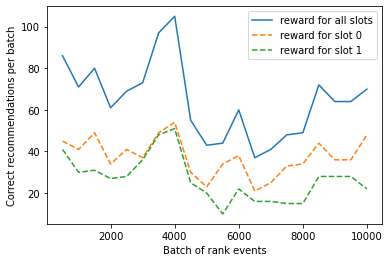

In [19]:
createChart(count, total_rewards, total_slot_rewards)

## Reading the chart

This chart shows the success of the model for the current default learning policy. 

The ideal target that by the end of the test, the loop is averaging a success rate that is close to one hundred percent minus the exploration. The default setting of exploration is 20%. 

`100-20=80`

This exploration setting is found in the Azure portal, for the Personalizer resource, in the Configurations tab, under the RESOURCE MANAGEMENT section 

In order to find a better learning policy, based on your data to the Rank API, run an [offline evaluation](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/how-to-offline-evaluation) in the portal for your Personalizer loop.

## Run an offline evaluation

1. In the Azure portal, open the Personalizer resource's **Evaluations** page.
1. Select **Create Evaluation**.
1. Enter the required data of evaluation name, and date range for the loop evaluation. The date range should include only the days you are focusing on for your evaluation. 

    The purpose of running this offline evaluation is to determine if there is a better learning policy for the features and actions used in this loop. To find that better learning policy, make sure **Optimization policy** is turned on.

1. Select **OK** to begin the evaluation. 
1. This **Evaluations** page lists the new evaluation and its current status. Depending on how much data you have, this evaluation can take some time. You can come back to this page after a few minutes to see the results. 
1. When the evaluation is completed, select the evaluation then select **Comparison of different learning policies**. This shows the available learning policies and how they would behave with the data. 
1. Select the top-most learning policy in the table and select **Apply**. This applies the _best_ learning policy to your model and retrains. 

## Validate new learning policy by running experiment for 5,000 iterations

Return to the Azure notebook, and continue by running the same loop but for only 5,000 iterations. Refresh the metrics chart in the Azure portal periodically to see the total calls to the service. When you have around 10,000 calls, a rank and reward call for each iteration of the loop, the iterations are done. 

In [ ]:
# max iterations
num_requests = 5000

# check last mod date N% of time - currently 10%
lastModCheck2 = int(num_requests * .10)

jsonTemplate2 = rankactionsjsonobj

# main iterations
[count2, total_rewards2, total_slot_rewards2] = iterations(num_requests, lastModCheck2, jsonTemplate2, 500)

1 Cathy 7 Evening Desktop BigHeroPosition 31-Inch-Monitor-771 0 
1 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
2 Alice 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
2 Alice 30 Morning Mobile SmallSidebar Tennis-Racket-133 1 
3 Alice 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
3 Alice 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
4 Cathy 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
4 Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
5 Cathy 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
5 Cathy 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
6 Alice 21 Morning Mobile BigHeroPosition 31-Inch-Monitor-771 0 
6 Alice 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
7 Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
7 Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
8 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
8 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 


66 Cathy 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
66 Cathy 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
67 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
67 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
68 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
68 Alice 7 Evening Mobile SmallSidebar XBox-Series X-117 0 
69 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
69 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
70 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
70 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
71 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
71 Alice 7 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
72 Cathy 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
72 Cathy 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
73 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
73 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-4

131 Alice 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
131 Alice 30 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
132 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
132 Bob 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
133 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
133 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
134 Cathy 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
134 Cathy 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
135 Alice 30 Evening Desktop BigHeroPosition 31-Inch-Monitor-771 0 
135 Alice 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
136 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
136 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
137 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
137 Bob 30 Morning Mobile SmallSidebar XBox-Series X-117 1 
138 Alice 21 Afternoon Desktop BigHeroPosition 31-Inch-Monitor-771 0 
138 Alice 21 Afternoon Desktop

194 Cathy 21 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
195 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
195 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
196 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
196 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
197 Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
197 Alice 21 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
198 Cathy 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
198 Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
199 Cathy 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
199 Cathy 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
200 Cathy 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
200 Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
201 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
201 Alice 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 1 
202 Alice 30 Morning Mob

258 Alice 30 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
259 Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
259 Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
260 Cathy 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
260 Cathy 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
261 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
261 Bob 21 Morning Mobile SmallSidebar XBox-Series X-117 0 
262 Bob 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
262 Bob 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
263 Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
263 Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
264 Bob 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
264 Bob 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
265 Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
265 Cathy 21 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
266 Bob 30 Morning Mobile BigHeroPosit

322 Alice 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
323 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
323 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
324 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
324 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
325 Alice 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
325 Alice 21 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
326 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
326 Bob 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
327 Alice 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
327 Alice 21 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
328 Alice 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
328 Alice 21 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
329 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
329 Bob 30 Morning Mobile SmallSidebar XBox-Series X-117 1 
330 Bob 7 Afternoon Desktop BigHeroPosition Tenn

386 Alice 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
387 Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
387 Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
388 Cathy 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
388 Cathy 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
389 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
389 Alice 7 Evening Mobile SmallSidebar XBox-Series X-117 0 
390 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
390 Cathy 7 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
391 Alice 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
391 Alice 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
392 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
392 Bob 30 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
393 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
393 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
394 Cathy 21 Morning Mobile BigH

450 Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
451 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
451 Cathy 7 Morning Desktop SmallSidebar XBox-Series X-117 0 
452 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
452 Bob 21 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
453 Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
453 Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
454 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
454 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
455 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
455 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
456 Cathy 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
456 Cathy 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
457 Alice 21 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
457 Alice 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
458 Bob 21 Afternoon Desktop BigHeroPositi

513 Cathy 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
513 Cathy 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
514 Cathy 21 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 1 
514 Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
515 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
515 Bob 30 Evening Mobile SmallSidebar XBox-Series X-117 0 
516 Bob 7 Evening Mobile BigHeroPosition XBox-Series X-117 0 
516 Bob 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
517 Cathy 30 Evening Mobile BigHeroPosition XBox-Series X-117 0 
517 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
518 Cathy 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
518 Cathy 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
519 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
519 Bob 30 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
520 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
520 Bob 7 Evening Mobile SmallSidebar XBox-Series X-

577 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
577 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
578 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
578 Alice 7 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
579 Alice 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
579 Alice 30 Evening Mobile SmallSidebar XBox-Series X-117 0 
580 Bob 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
580 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
581 Cathy 7 Evening Mobile BigHeroPosition XBox-Series X-117 0 
581 Cathy 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
582 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
582 Alice 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
583 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
583 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
584 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
584 Alice 7 Evening Mobile SmallS

641 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
641 Alice 7 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
642 Bob 30 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
642 Bob 30 Evening Mobile SmallSidebar XBox-Series X-117 0 
643 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
643 Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
644 Alice 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 1 
644 Alice 30 Evening Mobile SmallSidebar Tennis-Racket-133 0 
645 Alice 7 Evening Mobile BigHeroPosition XBox-Series X-117 0 
645 Alice 7 Evening Mobile SmallSidebar Tennis-Racket-133 0 
646 Bob 21 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
646 Bob 21 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
647 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
647 Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
648 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
648 Bob 7 Morning Desktop SmallSidebar XBo

705 Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
706 Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
706 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
707 Cathy 21 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
707 Cathy 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
708 Alice 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
708 Alice 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
709 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
709 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
710 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
710 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
711 Alice 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
711 Alice 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
712 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
712 Alice 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 1 
713 Cathy 21 Evening Mobil

769 Alice 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
770 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
770 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
771 Bob 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
771 Bob 30 Evening Desktop SmallSidebar XBox-Series X-117 0 
772 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
772 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
773 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
773 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
774 Alice 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
774 Alice 30 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
775 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
775 Bob 7 Evening Desktop SmallSidebar XBox-Series X-117 0 
776 Cathy 30 Afternoon Desktop BigHeroPosition Red-Polo-Shirt-432 0 
776 Cathy 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 1 
777 Cathy 21 Evening Desktop Big

833 Cathy 21 Afternoon Mobile SmallSidebar Tennis-Racket-133 0 
834 Bob 30 Afternoon Mobile BigHeroPosition 31-Inch-Monitor-771 0 
834 Bob 30 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
835 Alice 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
835 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
836 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
836 Bob 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
837 Cathy 21 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
837 Cathy 21 Afternoon Mobile SmallSidebar XBox-Series X-117 0 
838 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
838 Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
839 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
839 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
840 Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
840 Cathy 21 Evening Mobile SmallSidebar XBox-Series X-117 0 
841 Alice 21 Afternoon Desktop Big

897 Alice 30 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
898 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
898 Bob 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
899 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
899 Cathy 21 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
900 Cathy 30 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
900 Cathy 30 Morning Desktop SmallSidebar Tennis-Racket-133 0 
901 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
901 Alice 7 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
902 Cathy 7 Afternoon Mobile BigHeroPosition Red-Polo-Shirt-432 0 
902 Cathy 7 Afternoon Mobile SmallSidebar Tennis-Racket-133 1 
903 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
903 Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
904 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
904 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
905 Bob 7 Afternoon Mobile B

961 Bob 21 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
962 Bob 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
962 Bob 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
963 Bob 7 Morning Mobile BigHeroPosition XBox-Series X-117 0 
963 Bob 7 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
964 Cathy 30 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
964 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
965 Cathy 7 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
965 Cathy 7 Evening Mobile SmallSidebar XBox-Series X-117 0 
966 Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
966 Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
967 Bob 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
967 Bob 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
968 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
968 Cathy 30 Morning Mobile SmallSidebar XBox-Series X-117 0 
969 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-

1023 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1024 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1024 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1025 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1025 Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1026 Bob 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1026 Bob 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1027 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1027 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1028 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1028 Bob 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
1029 Alice 30 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1029 Alice 30 Morning Desktop SmallSidebar XBox-Series X-117 0 
1030 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1030 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1031 Cathy 21 Afternoon Mobile B

1086 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1087 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1087 Alice 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1088 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
1088 Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
1089 Alice 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1089 Alice 30 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
1090 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1090 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1091 Alice 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
1091 Alice 7 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
1092 Bob 21 Evening Mobile BigHeroPosition XBox-Series X-117 0 
1092 Bob 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
1093 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1093 Alice 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 1 
1094 Bob 21 Morning Mobile

1150 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1150 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1151 Alice 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1151 Alice 30 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
1152 Alice 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1152 Alice 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
1153 Cathy 21 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1153 Cathy 21 Evening Desktop SmallSidebar XBox-Series X-117 0 
1154 Cathy 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 1 
1154 Cathy 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
1155 Bob 7 Morning Mobile BigHeroPosition XBox-Series X-117 0 
1155 Bob 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1156 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
1156 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
1157 Cathy 30 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
1157 Cathy 30 Evening Mobi

1213 Alice 30 Afternoon Desktop BigHeroPosition XBox-Series X-117 0 
1213 Alice 30 Afternoon Desktop SmallSidebar Tennis-Racket-133 0 
1214 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1214 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1215 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
1215 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
1216 Bob 21 Morning Mobile BigHeroPosition 31-Inch-Monitor-771 0 
1216 Bob 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1217 Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1217 Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1218 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1218 Cathy 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1219 Alice 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
1219 Alice 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
1220 Alice 7 Afternoon Mobile BigHeroPosition XBox-Series X-117 0 
1220 Alice 7 Afternoon Mobile 

1276 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1276 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1277 Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1277 Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1278 Alice 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
1278 Alice 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
1279 Cathy 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1279 Cathy 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1280 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1280 Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
1281 Cathy 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1281 Cathy 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1282 Cathy 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1282 Cathy 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1283 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1283 Bob 7 Morni

1339 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1339 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1340 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1340 Bob 7 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
1341 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1341 Bob 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
1342 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1342 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1343 Cathy 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1343 Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1344 Alice 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
1344 Alice 21 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
1345 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
1345 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
1346 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1346 Cathy 7 A

1402 Cathy 30 Evening Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1402 Cathy 30 Evening Desktop SmallSidebar Tennis-Racket-133 0 
1403 Cathy 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1403 Cathy 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1404 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
1404 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
1405 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1405 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1406 Cathy 21 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
1406 Cathy 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
1407 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1407 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1408 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
1408 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1409 Alice 7 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1409 Alice 7 Evening Deskt

1465 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1466 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1466 Alice 7 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1467 Cathy 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1467 Cathy 7 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
1468 Bob 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1468 Bob 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1469 Bob 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1469 Bob 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1470 Bob 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1470 Bob 21 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 1 
1471 Cathy 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1471 Cathy 30 Afternoon Mobile SmallSidebar Red-Polo-Shirt-432 0 
1472 Bob 7 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
1472 Bob 7 Evening Mobile SmallSidebar Red-Polo-Shirt-432 0 
1473 Alice 21 Morning Mob

1527 Cathy 21 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1528 Alice 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
1528 Alice 30 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
1529 Cathy 30 Evening Mobile BigHeroPosition 31-Inch-Monitor-771 0 
1529 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
1530 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1530 Bob 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1531 Alice 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1531 Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1532 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1532 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1533 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1533 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
1534 Bob 7 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1534 Bob 7 Morning Desktop SmallSidebar Tennis-Racket-133 0 
1535 Bob 7 Morning M

1590 Alice 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1591 Alice 30 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1591 Alice 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 1 
1592 Bob 7 Evening Desktop BigHeroPosition XBox-Series X-117 0 
1592 Bob 7 Evening Desktop SmallSidebar Tennis-Racket-133 0 
1593 Alice 21 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
1593 Alice 21 Evening Mobile SmallSidebar 31-Inch-Monitor-771 0 
1594 Alice 21 Evening Desktop BigHeroPosition XBox-Series X-117 0 
1594 Alice 21 Evening Desktop SmallSidebar Tennis-Racket-133 0 
1595 Bob 7 Morning Mobile BigHeroPosition XBox-Series X-117 0 
1595 Bob 7 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1596 Bob 7 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1596 Bob 7 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1597 Alice 30 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1597 Alice 30 Evening Desktop SmallSidebar 31-Inch-Monitor-771 0 
1598 Cathy 21 Evening Mobile Big

1653 Alice 30 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 1 
1654 Bob 7 Evening Desktop BigHeroPosition Tennis-Racket-133 1 
1654 Bob 7 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1655 Alice 7 Afternoon Mobile BigHeroPosition Tennis-Racket-133 0 
1655 Alice 7 Afternoon Mobile SmallSidebar 31-Inch-Monitor-771 0 
1656 Cathy 30 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1656 Cathy 30 Evening Mobile SmallSidebar Tennis-Racket-133 1 
1657 Cathy 7 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1657 Cathy 7 Morning Mobile SmallSidebar 31-Inch-Monitor-771 0 
1658 Bob 21 Evening Desktop BigHeroPosition Tennis-Racket-133 0 
1658 Bob 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1659 Cathy 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1659 Cathy 30 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1660 Bob 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1660 Bob 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1661 Bob 7 Morning D

1716 Bob 30 Morning Mobile SmallSidebar XBox-Series X-117 1 
1717 Cathy 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1717 Cathy 30 Morning Mobile SmallSidebar Tennis-Racket-133 0 
1718 Bob 21 Morning Mobile BigHeroPosition Tennis-Racket-133 1 
1718 Bob 21 Morning Mobile SmallSidebar Red-Polo-Shirt-432 0 
1719 Alice 21 Afternoon Desktop BigHeroPosition Tennis-Racket-133 1 
1719 Alice 21 Afternoon Desktop SmallSidebar XBox-Series X-117 0 
1720 Cathy 21 Morning Desktop BigHeroPosition Red-Polo-Shirt-432 0 
1720 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
1721 Cathy 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1721 Cathy 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1722 Cathy 21 Evening Mobile BigHeroPosition Red-Polo-Shirt-432 0 
1722 Cathy 21 Evening Mobile SmallSidebar Tennis-Racket-133 0 
1723 Alice 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
1723 Alice 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
1724 Cathy 7 Evening Mobi

1779 Alice 21 Evening Desktop SmallSidebar Red-Polo-Shirt-432 0 
1780 Alice 7 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
1780 Alice 7 Morning Mobile SmallSidebar XBox-Series X-117 0 
1781 Alice 7 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1781 Alice 7 Afternoon Desktop SmallSidebar Red-Polo-Shirt-432 0 
1782 Bob 30 Afternoon Desktop BigHeroPosition Tennis-Racket-133 0 
1782 Bob 30 Afternoon Desktop SmallSidebar 31-Inch-Monitor-771 0 
1783 Bob 30 Evening Mobile BigHeroPosition Tennis-Racket-133 0 
1783 Bob 30 Evening Mobile SmallSidebar XBox-Series X-117 0 
1784 Bob 30 Morning Mobile BigHeroPosition Tennis-Racket-133 0 
1784 Bob 30 Morning Mobile SmallSidebar XBox-Series X-117 1 
1785 Cathy 21 Morning Desktop BigHeroPosition XBox-Series X-117 0 
1785 Cathy 21 Morning Desktop SmallSidebar Tennis-Racket-133 0 
1786 Alice 21 Morning Desktop BigHeroPosition Tennis-Racket-133 0 
1786 Alice 21 Morning Desktop SmallSidebar Red-Polo-Shirt-432 0 
1787 Alice 30 Evening Mobile

## Run chart for 5,000 rank requests

Run the `createChart` function.

In [ ]:
createChart(count2, total_rewards2, total_slot_rewards2)

## Review the second chart

The second chart should show a visible increase in Rank predictions aligning with user preferences. 

## Clean up resources

If you do not intend to continue the tutorial series, clean up the following resources:

* Delete your Azure Notebook project. 
* Delete your Personalizer resource. 